In [14]:
import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from arch import arch_model

To find the periods with low and high volatility, we could use the VIX index. However, this uses *expected* volatility, while we are more interested in *actual* volatility. Therefore, we calculate rolling volatility for all days, and use the 10% and 90% quantiles to define low and high volatility periods. We find the rolling volatility for a day $t$ with this formula:

$$
\text{volatility}(t) = \sqrt{\frac{1}{N} \sum_{i=0}^{N-1} (r_{t-i} - \bar{r})^2}
$$

Where $r_x$ is the return on day $x$, $\bar{r}$ is the average return, and $N$ is the number of days in the rolling window. We use a rolling window of 21 days (trading days in a month), and use the log returns (scaled by 100). We then smooth it using the 10-day moving average to stabilise the periods, as one day of high volatility could inadvertedly skew the results. Note that by using the stocks own quantiles we define the periods of low and high volatility based on the volatility of the stock itself, which is not an objective measure of the volatility of the stock compared to the market.

In [15]:
ticker = "PFE"
csv_filepath = f"data/{ticker}.csv"

df = pd.read_csv(csv_filepath, index_col='Date', parse_dates=True)
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)
df.index = pd.to_datetime(df.index, utc=True)

In [16]:
mean_return = df['Return'].mean()
df['e'] = df['Return'] - mean_return
df['Volatility'] = (df['e']) ** 2
df['unsmoothed_rolling_vol'] = df['Volatility'].rolling(window=21).mean()
# smooth it with 10 day MA
df['Rolling volatility'] = df['unsmoothed_rolling_vol'].rolling(window=10).mean()

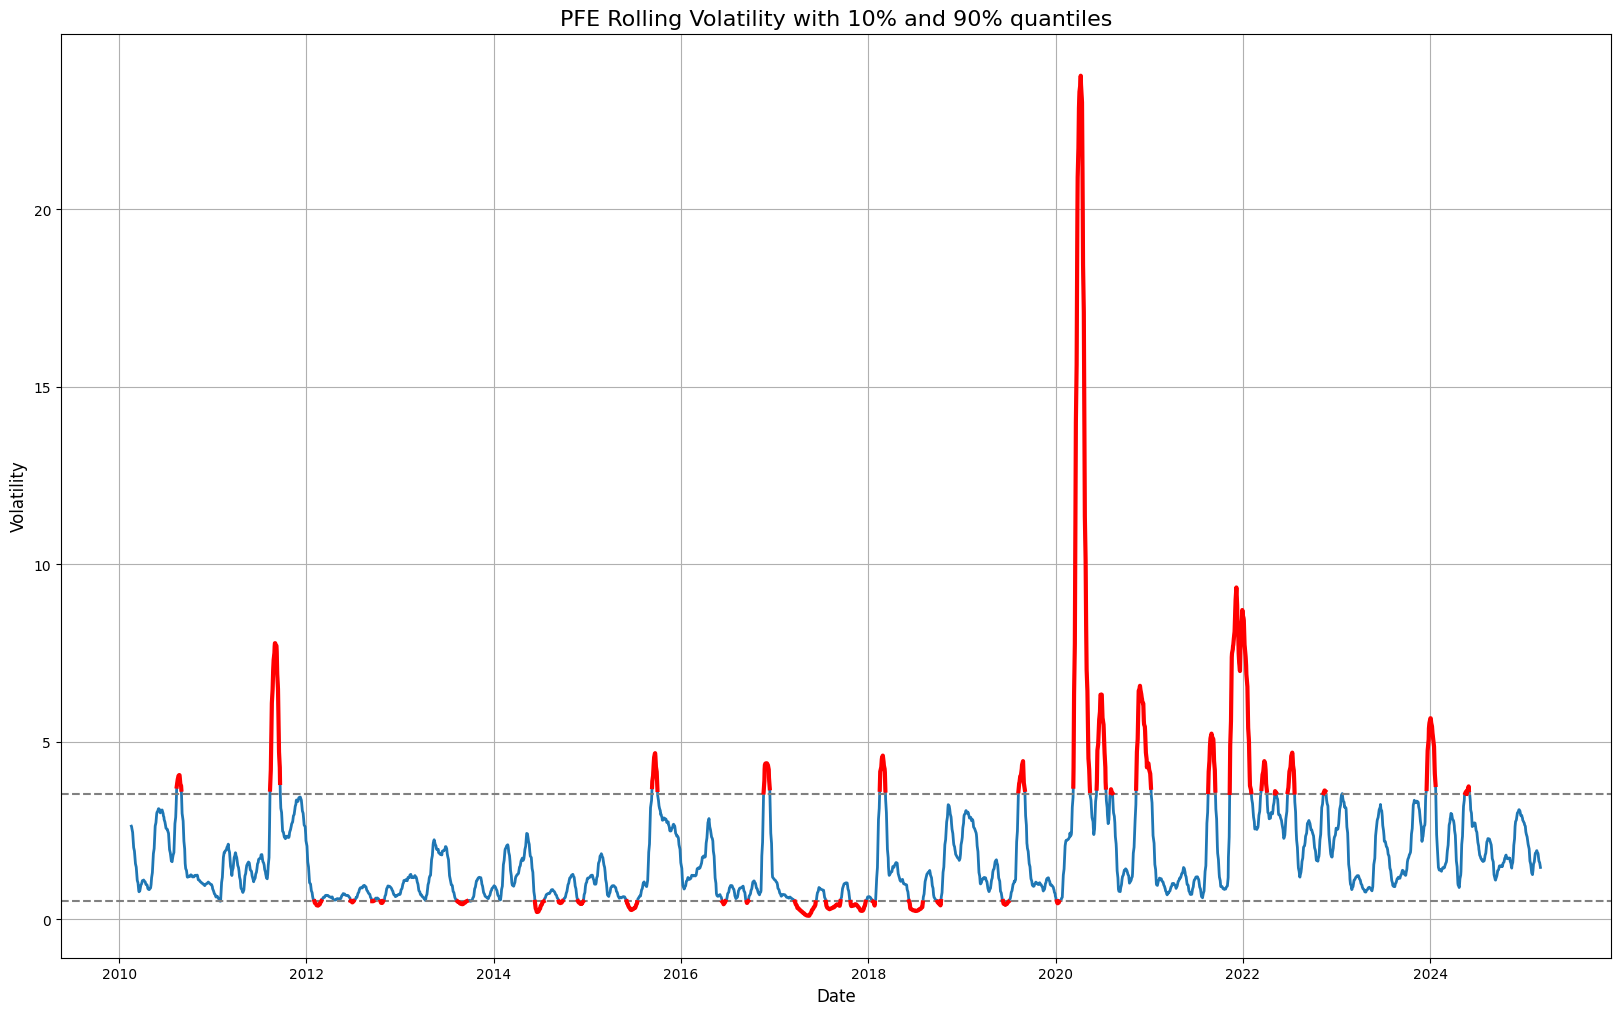

In [17]:
quantiles = df['Rolling volatility'].quantile([0.1, 0.9])
q_low = quantiles.loc[0.1]
q_high = quantiles.loc[0.9]

under = df['Rolling volatility'].where(
    (df['Rolling volatility'] < q_low)
)
over = df['Rolling volatility'].where(
    (df['Rolling volatility'] > q_high)
)
plt.figure(figsize=(20, 12))
plt.plot(df.index, df['Rolling volatility'], label="Rolling Volatility", linewidth=2)
plt.axhline(y=q_low, color='gray', linestyle='--', label='10% quantile')
plt.axhline(y=q_high, color='gray', linestyle='--', label='90% quantile')
plt.plot(df.index, over, color='red', linewidth=3)
plt.plot(df.index, under, color='red', linewidth=3)
plt.title(f"{ticker} Rolling Volatility with 10% and 90% quantiles", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.grid(True)
plt.show()

Here we test GARCH and GJR-GARCH models and look at their RMSE for different volatility periods. The results look as expected.

I thought we would just plug-and-play a bunch of different models, but based on [this](https://arch.readthedocs.io/en/latest/univariate/forecasting.html) it seems like we might need to use some other adjustments for things like EGARCH. Anyways, there is lots to try by just plotting a few ARCH-models and trying different p and q values, and we won't struggle with having something to talk about if we have 3+ models to compare.

100%|██████████| 3544/3544 [00:14<00:00, 247.04it/s]


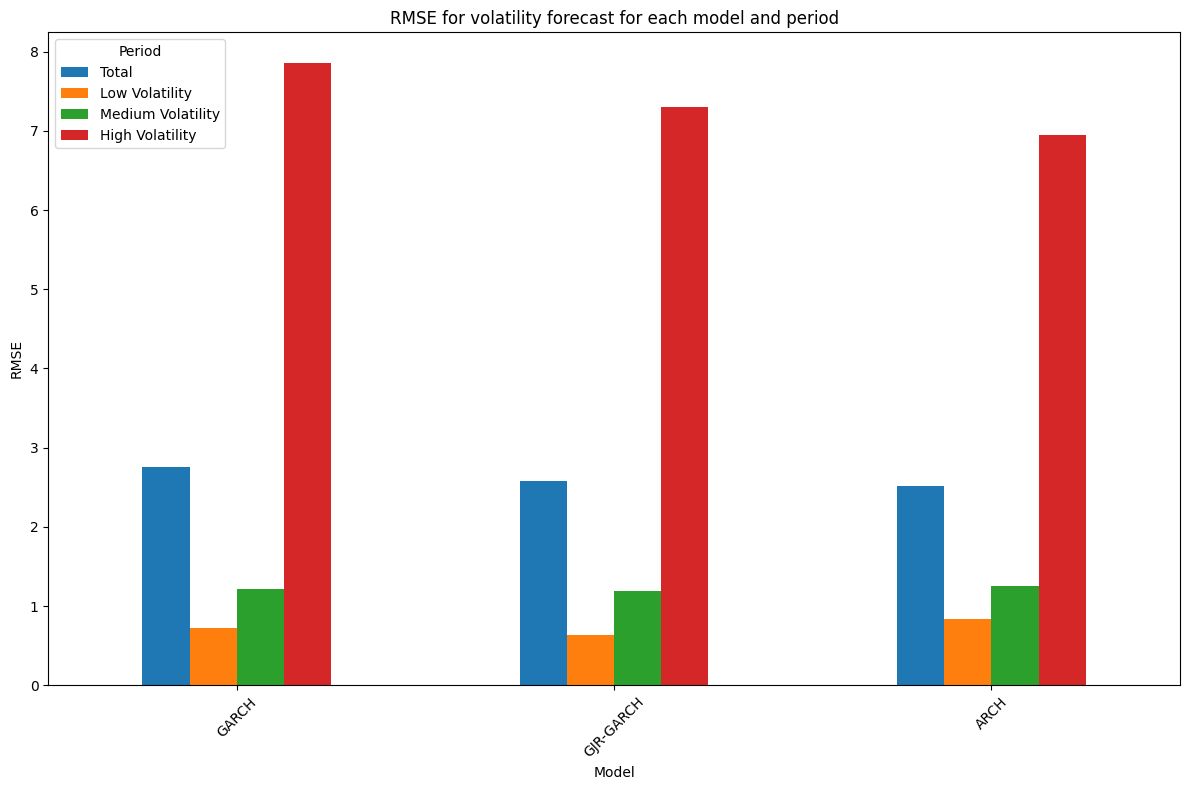

In [18]:
models = [
    {'name': 'GARCH', 'vol': 'GARCH', 'p': 1, 'q': 1},
    {'name': 'GJR-GARCH', 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1},
    {'name': 'ARCH', 'vol': 'ARCH', 'p': 1, 'q': 0}
]

forecast_results = {}
for model_spec in models:
    forecasts, actuals, regimes, dates = [], [], [], []
    for t in tqdm.tqdm(range(252, len(df) - 21)):
        train_data = df.iloc[t-252:t]['e']
        if not np.isfinite(train_data).all():
            continue
        model = arch_model(
            train_data, mean='Zero', vol=model_spec['vol'], 
            p=model_spec['p'], q=model_spec['q'], o=model_spec.get('o', 0)
        )
        res = model.fit(disp='off')
        forecasts_horizon = res.forecast(horizon=21)
        f_t = forecasts_horizon.variance.iloc[0, :].mean()
        actual = df['unsmoothed_rolling_vol'].iloc[t+21]
        regime = df['Rolling volatility'].iloc[t+21]
        forecasts.append(f_t)
        actuals.append(actual)
        regimes.append(regime)
        dates.append(df.index[t+21])
    
    forecast_df = pd.DataFrame({'forecast': forecasts, 'actual': actuals, 'regime': regimes}, index=dates)
    forecast_df = forecast_df[np.isfinite(forecast_df['forecast']) & np.isfinite(forecast_df['actual'])]
    
    rmse_overall = np.sqrt(np.mean((forecast_df['forecast'] - forecast_df['actual'])**2))
    low_vol = forecast_df[forecast_df['regime'] < q_low]
    rmse_low = np.sqrt(np.mean((low_vol['forecast'] - low_vol['actual'])**2)) if not low_vol.empty else np.nan
    high_vol = forecast_df[forecast_df['regime'] > q_high]
    rmse_high = np.sqrt(np.mean((high_vol['forecast'] - high_vol['actual'])**2)) if not high_vol.empty else np.nan
    med_vol = forecast_df[(forecast_df['regime'] >= q_low) & (forecast_df['regime'] <= q_high)]
    rmse_med = np.sqrt(np.mean((med_vol['forecast'] - med_vol['actual'])**2)) if not med_vol.empty else np.nan
    
    forecast_results[model_spec['name']] = {
        'rmse_overall': rmse_overall, 'rmse_low': rmse_low, 
        'rmse_med': rmse_med, 'rmse_high': rmse_high, 'forecast_df': forecast_df
    }

rmse_data = {
    'Total': [forecast_results[model]['rmse_overall'] for model in forecast_results],
    'Low Volatility': [forecast_results[model]['rmse_low'] for model in forecast_results],
    'Medium Volatility': [forecast_results[model]['rmse_med'] for model in forecast_results],
    'High Volatility': [forecast_results[model]['rmse_high'] for model in forecast_results]
}
rmse_df = pd.DataFrame(rmse_data, index=[model['name'] for model in models])
rmse_df.plot(kind='bar', figsize=(12, 8))
plt.title('RMSE for volatility forecast for each model and period')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.tight_layout()
plt.show()

In [ ]:
import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from arch import arch_model
import warnings
import os
from joblib import Parallel, delayed

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*Dtype inference on a pandas object.*"
)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*ConvergenceWarning.*"
)

tickers = ["XOM", "META", "PFE", "WMT", "TSLA"]
data_dir = "data/"
rolling_window = 21
smoothing_window = 10
train_window = 252 
forecast_horizon = 21
n_jobs = 10 

models_to_run = [
    {'name': 'GARCH(1,1)', 'vol': 'GARCH', 'p': 1, 'q': 1},
    {'name': 'GJR-GARCH(1,1)', 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1},
    {'name': 'ARCH(1)', 'vol': 'ARCH', 'p': 1, 'q': 0}
]

all_stock_results = {}
all_stock_data = {}

In [ ]:
for ticker in tickers:
    print(f"Processing {ticker}...")
    csv_filepath = os.path.join(data_dir, f"{ticker}.csv")

    try:
        df = pd.read_csv(csv_filepath, index_col='Date', parse_dates=True)
    except FileNotFoundError:
        print(f"Warning: Data file not found for {ticker} at {csv_filepath}. Skipping.")
        continue

    df['Return'] = np.log(df['Close']).diff() * 100
    df = df.dropna(subset=['Return'])

    if df.empty:
        print(f"Warning: No return data for {ticker}. Skipping.")
        continue

    mean_return = df['Return'].mean()
    df['e'] = df['Return'] - mean_return 
    df['Volatility'] = (df['e']) ** 2 

    df['unsmoothed_rolling_vol'] = df['Volatility'].rolling(window=rolling_window).mean()

    df['Rolling volatility'] = df['unsmoothed_rolling_vol'].rolling(window=smoothing_window).mean()

    df = df.dropna(subset=['Rolling volatility'])

    if df.empty:
        print(f"Warning: Not enough data after calculating rolling windows for {ticker}. Skipping.")
        continue

    quantiles = df['Rolling volatility'].quantile([0.1, 0.9])
    df['q_low'] = quantiles.loc[0.1]
    df['q_high'] = quantiles.loc[0.9]

    all_stock_data[ticker] = df
    print(f"Finished processing {ticker}.")

tickers = list(all_stock_data.keys())
if not tickers:
    raise ValueError("No stock data could be processed. Check file paths and data integrity.")

Processing XOM...
Finished processing XOM.
Processing META...
Finished processing META.
Processing PFE...
Finished processing PFE.
Processing WMT...
Finished processing WMT.
Processing TSLA...
Finished processing TSLA.


In [ ]:
def run_rolling_forecast_for_model(ticker, model_spec, df, train_window, forecast_horizon):
    import warnings
    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message=".*Dtype inference on a pandas object.*"
    )
    warnings.filterwarnings(
        "ignore",
        category=UserWarning, 
        message=".*ConvergenceWarning.*"
    )

    model_name = model_spec['name']

    q_low = df['q_low'].iloc[0]
    q_high = df['q_high'].iloc[0]

    if len(df) < train_window + forecast_horizon:
        return ticker, model_name, None 

    forecasts, actuals, regimes, dates = [], [], [], []

    for t in range(train_window, len(df) - forecast_horizon):
        train_data = df.iloc[t-train_window : t]['e']

        if not np.isfinite(train_data).all() or train_data.empty:
            continue

        model = arch_model(
            train_data, mean='Zero',
            vol=model_spec['vol'],
            p=model_spec['p'],
            q=model_spec['q'],
            o=model_spec.get('o', 0)
        )

        try:
            res = model.fit(disp='off', show_warning=False) 
            forecasts_horizon = res.forecast(horizon=forecast_horizon, reindex=False)
            f_t = forecasts_horizon.variance.iloc[0].mean()
            actual = df['unsmoothed_rolling_vol'].iloc[t + forecast_horizon - 1]
            regime_vol = df['Rolling volatility'].iloc[t + forecast_horizon - 1]

            if np.isfinite(f_t) and np.isfinite(actual) and np.isfinite(regime_vol):
                forecasts.append(f_t)
                actuals.append(actual)
                regimes.append(regime_vol)
                dates.append(df.index[t + forecast_horizon - 1])
        except Exception as e:
            continue

    if not dates:
         results = {
             'rmse_overall': np.nan, 'rmse_low': np.nan, 'rmse_med': np.nan,
             'rmse_high': np.nan, 'forecast_df': pd.DataFrame()
         }
         return ticker, model_name, results 


    forecast_df = pd.DataFrame({'forecast': forecasts, 'actual': actuals, 'regime_vol': regimes}, index=dates)

    rmse_overall = np.sqrt(np.mean((forecast_df['forecast'] - forecast_df['actual'])**2))
    low_vol_df = forecast_df[forecast_df['regime_vol'] < q_low]
    rmse_low = np.sqrt(np.mean((low_vol_df['forecast'] - low_vol_df['actual'])**2)) if not low_vol_df.empty else np.nan
    high_vol_df = forecast_df[forecast_df['regime_vol'] > q_high]
    rmse_high = np.sqrt(np.mean((high_vol_df['forecast'] - high_vol_df['actual'])**2)) if not high_vol_df.empty else np.nan
    med_vol_df = forecast_df[(forecast_df['regime_vol'] >= q_low) & (forecast_df['regime_vol'] <= q_high)]
    rmse_med = np.sqrt(np.mean((med_vol_df['forecast'] - med_vol_df['actual'])**2)) if not med_vol_df.empty else np.nan

    results = {
        'rmse_overall': rmse_overall, 'rmse_low': rmse_low,
        'rmse_med': rmse_med, 'rmse_high': rmse_high,
        'forecast_df': forecast_df 
    }
    return ticker, model_name, results

tasks = []
for ticker in tickers:
    if ticker in all_stock_data: 
        df_ticker = all_stock_data[ticker]
        for model_spec in models_to_run:
            tasks.append((ticker, model_spec, df_ticker))

print(f"\nRunning {len(tasks)} model fits in parallel using {os.cpu_count() if n_jobs == -1 else n_jobs} cores...")
results_list = Parallel(n_jobs=n_jobs, prefer="processes", verbose=10)(
    delayed(run_rolling_forecast_for_model)(
        ticker, spec, df, train_window, forecast_horizon
    ) for ticker, spec, df in tasks 
)

all_stock_results = {ticker: {} for ticker in tickers if ticker in all_stock_data}
for result in results_list:
    if result is not None:
        ticker, model_name, results_dict = result
        if ticker in all_stock_results and results_dict is not None:
            all_stock_results[ticker][model_name] = results_dict

print("\nFinished all model fitting and forecasting.")


Running 15 model fits in parallel using 10 cores...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  15 | elapsed:   42.8s remaining:  4.6min
[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:  1.4min remaining:  3.9min
[Parallel(n_jobs=10)]: Done   6 out of  15 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=10)]: Done   8 out of  15 | elapsed:  2.0min remaining:  1.7min
[Parallel(n_jobs=10)]: Done  10 out of  15 | elapsed:  2.1min remaining:  1.1min
[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:  2.4min remaining:   35.3s



Finished all model fitting and forecasting.


[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:  2.6min finished


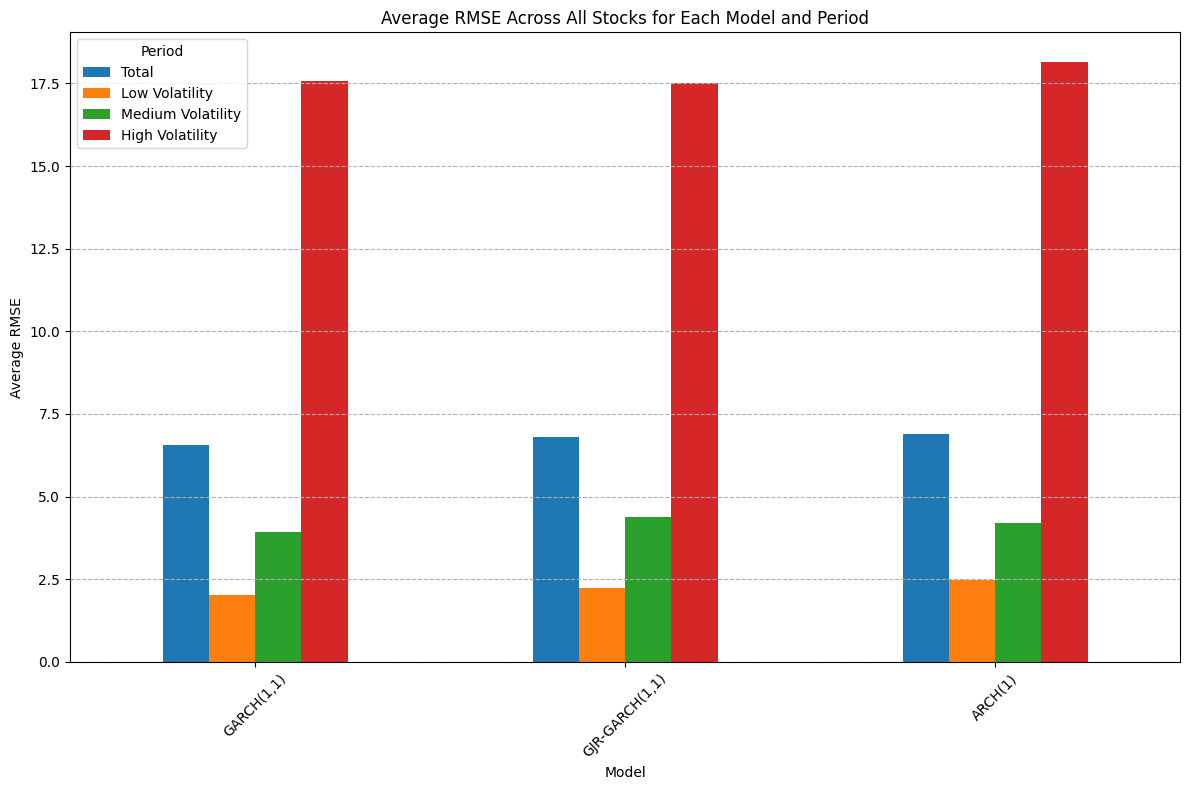


Average RMSE Table:
                   Total  Low Volatility  Medium Volatility  High Volatility
GARCH(1,1)      6.562482        2.039803           3.923718        17.574998
GJR-GARCH(1,1)  6.805080        2.227131           4.399544        17.518370
ARCH(1)         6.889728        2.484546           4.194437        18.135964


In [ ]:
avg_rmse_data = {
    'Total': [],
    'Low Volatility': [],
    'Medium Volatility': [],
    'High Volatility': []
}
model_names = [m['name'] for m in models_to_run]

for model_name in model_names:
    rmses_overall, rmses_low, rmses_med, rmses_high = [], [], [], []
    for ticker in tickers:
        if ticker in all_stock_results and model_name in all_stock_results.get(ticker, {}):
            results = all_stock_results[ticker][model_name]
            if results and not pd.isna(results.get('rmse_overall')):
                 rmses_overall.append(results['rmse_overall'])
                 rmses_low.append(results['rmse_low'])
                 rmses_med.append(results['rmse_med'])
                 rmses_high.append(results['rmse_high'])
            else: 
                 rmses_overall.append(np.nan)
                 rmses_low.append(np.nan)
                 rmses_med.append(np.nan)
                 rmses_high.append(np.nan)
        else:
             rmses_overall.append(np.nan)
             rmses_low.append(np.nan)
             rmses_med.append(np.nan)
             rmses_high.append(np.nan)


    avg_rmse_data['Total'].append(np.nanmean(rmses_overall) if not all(np.isnan(rmses_overall)) else np.nan)
    avg_rmse_data['Low Volatility'].append(np.nanmean(rmses_low) if not all(np.isnan(rmses_low)) else np.nan)
    avg_rmse_data['Medium Volatility'].append(np.nanmean(rmses_med) if not all(np.isnan(rmses_med)) else np.nan)
    avg_rmse_data['High Volatility'].append(np.nanmean(rmses_high) if not all(np.isnan(rmses_high)) else np.nan)


avg_rmse_df = pd.DataFrame(avg_rmse_data, index=model_names)

fig_agg, ax_agg = plt.subplots(figsize=(12, 8))
avg_rmse_df.plot(kind='bar', ax=ax_agg)
ax_agg.set_title('Average RMSE Across All Stocks for Each Model and Period')
ax_agg.set_ylabel('Average RMSE')
ax_agg.set_xlabel('Model')
ax_agg.tick_params(axis='x', rotation=45)
ax_agg.legend(title='Period')
ax_agg.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("\nAverage RMSE Table:")
print(avg_rmse_df)

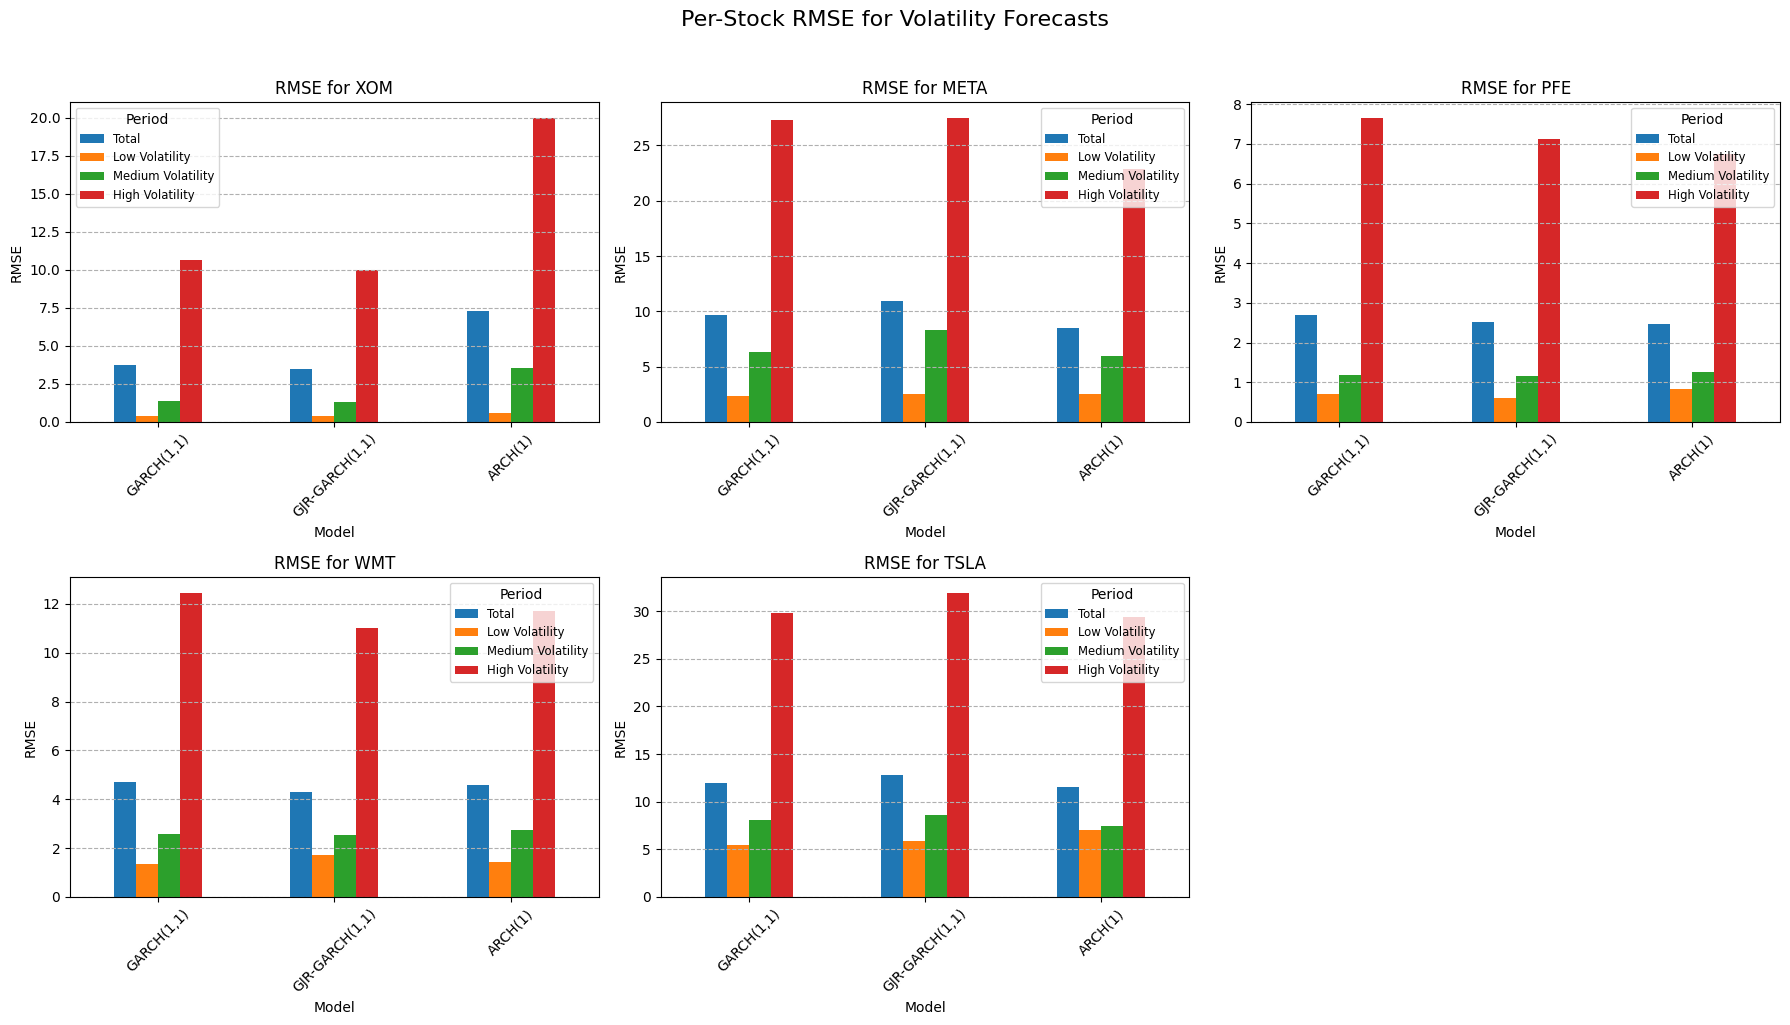

In [ ]:
n_stocks = len(tickers)
n_cols = 3
n_rows = (n_stocks + n_cols - 1) // n_cols

fig_sub, axes_sub = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), squeeze=False)
axes_flat = axes_sub.flatten()

for i, ticker in enumerate(tickers):
    ax = axes_flat[i]
    stock_results = all_stock_results.get(ticker, {})

    if not stock_results:
         ax.set_title(f"{ticker} (No Data/Results)")
         ax.text(0.5, 0.5, "No results available", ha='center', va='center')
         ax.set_xticks([])
         ax.set_yticks([])
         continue

    rmse_data = {
        'Total': [stock_results.get(model_name, {}).get('rmse_overall', np.nan) for model_name in model_names],
        'Low Volatility': [stock_results.get(model_name, {}).get('rmse_low', np.nan) for model_name in model_names],
        'Medium Volatility': [stock_results.get(model_name, {}).get('rmse_med', np.nan) for model_name in model_names],
        'High Volatility': [stock_results.get(model_name, {}).get('rmse_high', np.nan) for model_name in model_names]
    }
    rmse_df = pd.DataFrame(rmse_data, index=model_names)

    rmse_df.plot(kind='bar', ax=ax)
    ax.set_title(f'RMSE for {ticker}')
    ax.set_ylabel('RMSE')
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Period', fontsize='small')
    ax.grid(axis='y', linestyle='--')

for j in range(i + 1, n_rows * n_cols):
    fig_sub.delaxes(axes_flat[j])

plt.suptitle('Per-Stock RMSE for Volatility Forecasts', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

We only test p=1 and p=2 because tests showed that higher p values give worse results. Higher values for q have, however, shown promise, so we test test these up to q=8.

In [ ]:
p_values = [1, 2, 3]
q_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

pq_avg_results = {}

def run_rolling_forecast_for_pq(ticker, p, q, df, train_window, forecast_horizon):
    import warnings
    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message=".*Dtype inference on a pandas object.*"
    )
    warnings.filterwarnings(
        "ignore",
        category=UserWarning, 
        message=".*ConvergenceWarning.*"
    )

    q_low = df['q_low'].iloc[0]
    q_high = df['q_high'].iloc[0]

    if len(df) < train_window + forecast_horizon:
        return ticker, p, q, None 

    forecasts, actuals, regimes, dates = [], [], [], []

    for t in range(train_window, len(df) - forecast_horizon):
        train_data = df.iloc[t-train_window : t]['e']
        if not np.isfinite(train_data).all() or train_data.empty: continue

        model = arch_model(train_data, mean='Zero', vol='GARCH', p=p, q=q)
        try:
            res = model.fit(disp='off', show_warning=False) 
            forecasts_horizon = res.forecast(horizon=forecast_horizon, reindex=False)
            f_t = forecasts_horizon.variance.iloc[0].mean()
            actual = df['unsmoothed_rolling_vol'].iloc[t + forecast_horizon - 1]
            regime_vol = df['Rolling volatility'].iloc[t + forecast_horizon - 1]

            if np.isfinite(f_t) and np.isfinite(actual) and np.isfinite(regime_vol):
                forecasts.append(f_t)
                actuals.append(actual)
                regimes.append(regime_vol)
                dates.append(df.index[t + forecast_horizon - 1])
        except Exception:
            continue

    if not dates:
         results = {
             'rmse_overall': np.nan, 'rmse_low': np.nan, 'rmse_med': np.nan, 'rmse_high': np.nan
         }
         return ticker, p, q, results


    forecast_df = pd.DataFrame({'forecast': forecasts, 'actual': actuals, 'regime_vol': regimes}, index=dates)

    rmse_overall = np.sqrt(np.mean((forecast_df['forecast'] - forecast_df['actual'])**2))
    low_vol_df = forecast_df[forecast_df['regime_vol'] < q_low]
    rmse_low = np.sqrt(np.mean((low_vol_df['forecast'] - low_vol_df['actual'])**2)) if not low_vol_df.empty else np.nan
    high_vol_df = forecast_df[forecast_df['regime_vol'] > q_high]
    rmse_high = np.sqrt(np.mean((high_vol_df['forecast'] - high_vol_df['actual'])**2)) if not high_vol_df.empty else np.nan
    med_vol_df = forecast_df[(forecast_df['regime_vol'] >= q_low) & (forecast_df['regime_vol'] <= q_high)]
    rmse_med = np.sqrt(np.mean((med_vol_df['forecast'] - med_vol_df['actual'])**2)) if not med_vol_df.empty else np.nan

    results = {
        'rmse_overall': rmse_overall, 'rmse_low': rmse_low,
        'rmse_med': rmse_med, 'rmse_high': rmse_high
    }
    return ticker, p, q, results


pq_tasks = []
for ticker in tickers:
    if ticker in all_stock_data:
        df_ticker = all_stock_data[ticker]
        for p in p_values:
            for q in q_values:
                if p == 0 and q == 0: continue 
                pq_tasks.append((ticker, p, q, df_ticker))

print(f"\nRunning {len(pq_tasks)} GARCH(p,q) evaluations in parallel using {os.cpu_count() if n_jobs == -1 else n_jobs} cores...")
pq_results_list = Parallel(n_jobs=n_jobs, prefer="processes", verbose=10)(
    delayed(run_rolling_forecast_for_pq)(
        ticker, p, q, df, train_window, forecast_horizon
    ) for ticker, p, q, df in pq_tasks 
)

temp_pq_aggregation = {} 

for result in pq_results_list:
    if result is not None:
        ticker, p, q, results_dict = result
        if results_dict is not None: 
            pq_key = (p, q)
            if pq_key not in temp_pq_aggregation:
                temp_pq_aggregation[pq_key] = []
            temp_pq_aggregation[pq_key].append(results_dict)

pq_avg_results = {}
for pq_key, results_list_for_pq in temp_pq_aggregation.items():
    p, q = pq_key
    rmses_overall = [r['rmse_overall'] for r in results_list_for_pq]
    rmses_low = [r['rmse_low'] for r in results_list_for_pq]
    rmses_med = [r['rmse_med'] for r in results_list_for_pq]
    rmses_high = [r['rmse_high'] for r in results_list_for_pq]

    pq_avg_results[pq_key] = {
        'rmse_overall': np.nanmean(rmses_overall) if not all(np.isnan(rmses_overall)) else np.nan,
        'rmse_low': np.nanmean(rmses_low) if not all(np.isnan(rmses_low)) else np.nan,
        'rmse_med': np.nanmean(rmses_med) if not all(np.isnan(rmses_med)) else np.nan,
        'rmse_high': np.nanmean(rmses_high) if not all(np.isnan(rmses_high)) else np.nan
    }

print("\nFinished all GARCH(p,q) parameter tuning.")


Running 165 GARCH(p,q) evaluations in parallel using 10 cores...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 10.7min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 14.6min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 19.4min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 23.0min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 28.0min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 33.5min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 40.2min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 45.9min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 53.9min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 59.5min
[Parallel(n_jobs=10)]: Done 163 out of 165 | elapsed: 67.1min remaining:   49.4s



Finished all GARCH(p,q) parameter tuning.


[Parallel(n_jobs=10)]: Done 165 out of 165 | elapsed: 67.6min finished


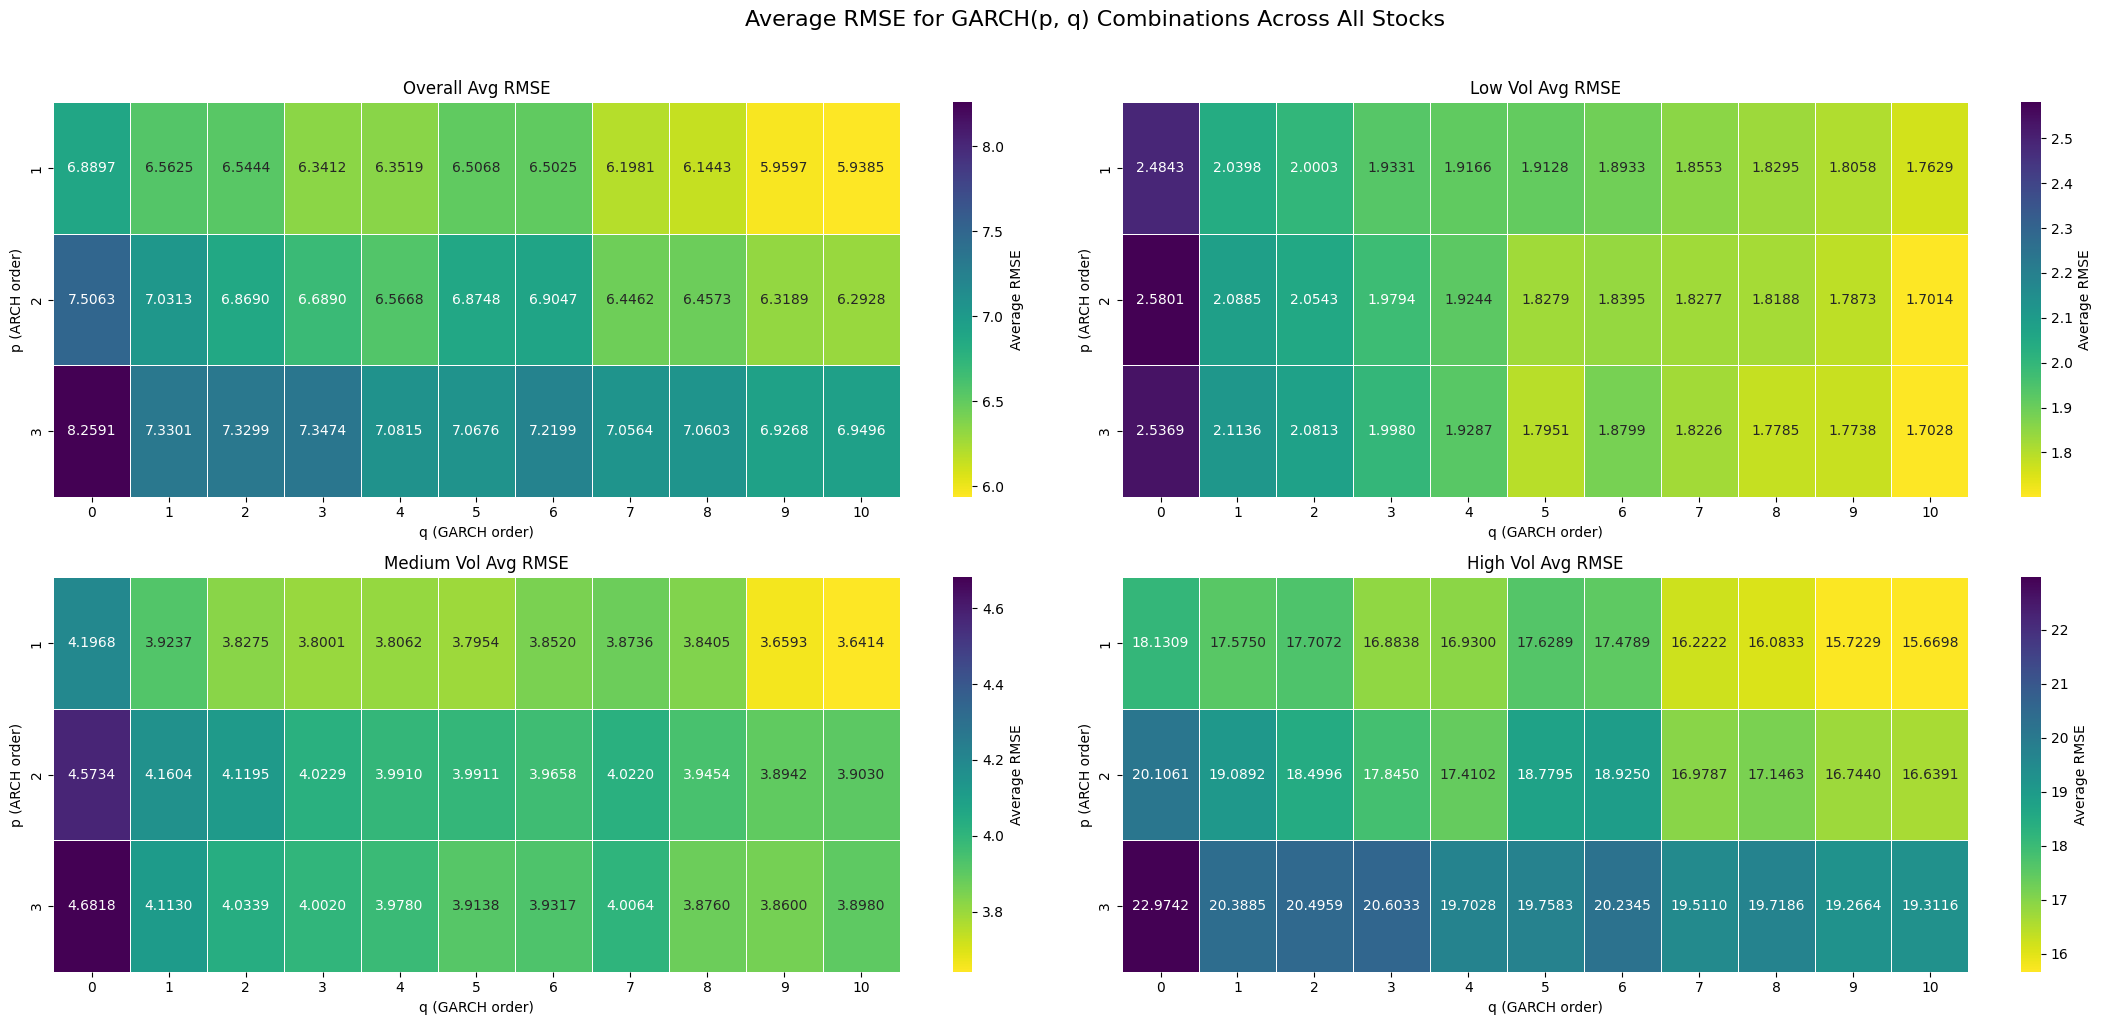


Average RMSE Table for GARCH(p,q) Tuning:
      rmse_overall  rmse_low  rmse_med  rmse_high
p q                                              
1 0       6.889679  2.484305  4.196838  18.130880
  1       6.562482  2.039803  3.923718  17.574998
  2       6.544401  2.000269  3.827477  17.707211
  3       6.341237  1.933117  3.800146  16.883752
  4       6.351873  1.916615  3.806159  16.929987
  5       6.506843  1.912764  3.795363  17.628949
  6       6.502537  1.893294  3.851969  17.478927
  7       6.198065  1.855308  3.873557  16.222211
  8       6.144337  1.829541  3.840507  16.083338
  9       5.959656  1.805805  3.659294  15.722857
  10      5.938459  1.762882  3.641379  15.669784
2 0       7.506288  2.580055  4.573401  20.106147
  1       7.031342  2.088513  4.160364  19.089245
  2       6.868951  2.054251  4.119510  18.499640
  3       6.688953  1.979394  4.022895  17.844956
  4       6.566814  1.924365  3.991043  17.410161
  5       6.874808  1.827924  3.991106  18.779538
  6    

In [ ]:
rmse_types = ['rmse_overall', 'rmse_low', 'rmse_med', 'rmse_high']
heatmap_data = {rtype: pd.DataFrame(index=p_values, columns=q_values, dtype=float) for rtype in rmse_types}

for (p, q), results in pq_avg_results.items():
    if p in p_values and q in q_values: 
        for rtype in rmse_types:
             if results: 
                heatmap_data[rtype].loc[p, q] = results.get(rtype, np.nan) 
             else:
                 heatmap_data[rtype].loc[p, q] = np.nan


fig_pq, axes_pq = plt.subplots(2, 2, figsize=(22, 10))
axes_pq_flat = axes_pq.flatten()
plot_titles = ['Overall Avg RMSE', 'Low Vol Avg RMSE', 'Medium Vol Avg RMSE', 'High Vol Avg RMSE']

for i, rtype in enumerate(rmse_types):
    ax = axes_pq_flat[i]
    data_to_plot = heatmap_data[rtype].dropna(axis=0, how='all').dropna(axis=1, how='all')
    if not data_to_plot.empty:
        sns.heatmap(data_to_plot, annot=True, fmt=".4f", cmap="viridis_r", ax=ax, 
                    linewidths=.5, cbar_kws={'label': 'Average RMSE'})
    else:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center')
    ax.set_title(plot_titles[i])
    ax.set_xlabel('q (GARCH order)')
    ax.set_ylabel('p (ARCH order)')

plt.suptitle('Average RMSE for GARCH(p, q) Combinations Across All Stocks', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

pq_results_list = []
for (p, q), results in pq_avg_results.items():
    if results: 
        row = {'p': p, 'q': q, **results}
        pq_results_list.append(row)

if pq_results_list:
    pq_results_df = pd.DataFrame(pq_results_list).set_index(['p', 'q']).sort_index()
    print("\nAverage RMSE Table for GARCH(p,q) Tuning:")
    print(pq_results_df)
else:
    print("\nNo valid results generated for GARCH(p,q) tuning.")